In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ecdf
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

pd.options.mode.chained_assignment = None

SEED = 69

# Sessa Empirical Estimator (SEE)

Sessa Empirical Estimator (SEE) – An Implementation in Python.

## Objectives

1. Compute the temporal intervals (gaps) between consecutive fills.
2. Filter out extremely long gaps by retaining only the lower 80% of the empirical cumulative distribution.
3. Standardize these intervals.
4. Cluster the standardized intervals using:
   - **K-Means**: As in the original SEE
   - **Density-Based Spatial Clustering of Applications with Noise (DBSCAN)**: As an alternative clustering method
5. Use the median of each cluster’s intervals as the estimated duration.
6. Compare the results between the two clustering approaches.

## Dataset

We will be using an artificial data set [`med_events.csv`](med_events.csv). The file is generated from `med.events` from [AdhereR](https://rdrr.io/cran/AdhereR/man/med.events.html).

In [2]:
med_events = pd.read_csv("med_events.csv")

med_events["DATE"] = pd.to_datetime(med_events["DATE"])

med_events.groupby("PATIENT_ID").first().head(10)

,DATE,PERDAY,CATEGORY,DURATION
PATIENT_ID,,,,
1,2033-04-26,4,medA,50
2,2036-01-20,4,medA,50
3,2042-04-13,4,medA,50
4,2032-05-01,4,medA,50
5,2031-10-26,8,medA,30
6,2037-01-07,4,medA,50
7,2042-04-05,2,medA,100
8,2034-04-08,6,medA,50
9,2032-03-01,2,medA,50


We will be making a copy of `med_events` with different column names:

- `pnr`: Patient ID
- `eksd`: Dispensing date in `MM/DD/YYYY` format
- `perday`: The daily dosage interval
- `ATC`: Anatomical Therapeutic Chemical
- `dur_original`: Original duration of the medication

In [3]:
tidy = med_events.copy()

tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]

tidy.groupby("pnr").first().head(10)

,eksd,perday,ATC,dur_original
pnr,,,,
1,2033-04-26,4,medA,50
2,2036-01-20,4,medA,50
3,2042-04-13,4,medA,50
4,2032-05-01,4,medA,50
5,2031-10-26,8,medA,30
6,2037-01-07,4,medA,50
7,2042-04-05,2,medA,100
8,2034-04-08,6,medA,50
9,2032-03-01,2,medA,50


## SEE Using K-Means Clustering

In [4]:
def SEE_KMeans(atc: str, data=tidy) -> pd.DataFrame:
    df = data[data["ATC"] == atc].copy()

    drug_see_p0 = df.copy()
    drug_see_p1 = df.copy()

    drug_see_p1 = drug_see_p1.sort_values(by=["pnr", "eksd"])
    drug_see_p1["prev_eksd"] = drug_see_p1.groupby("pnr")["eksd"].shift(1)
    drug_see_p1 = drug_see_p1.dropna(subset=["prev_eksd"])

    drug_see_p1 = (
        drug_see_p1.groupby("pnr")
        .apply(lambda x: x.sample(1, random_state=SEED), include_groups=False)
        .reset_index()
    )
    drug_see_p1 = drug_see_p1[["pnr", "eksd", "prev_eksd"]]
    drug_see_p1["event.interval"] = (
        drug_see_p1["eksd"] - drug_see_p1["prev_eksd"]
    ).dt.days

    per = ecdf(drug_see_p1["event.interval"])
    x = per.cdf.quantiles
    y = per.cdf.probabilities

    dfper = pd.DataFrame({"x": x, "y": y})
    dfper = dfper[dfper["y"] <= 0.8]

    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(dfper["x"], dfper["y"], label="80% ECDF")
    ax1.set_title("80% ECDF")
    ax1.set_xlabel("Event interval")
    ax1.set_ylabel("Cumulative Probability")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(x, y, label="100% ECDF")
    ax2.set_title("100% ECDF")
    ax2.set_xlabel("Event interval")
    ax2.set_ylabel("Cumulative Probability")

    ni = dfper["x"].max()
    drug_see_p2 = drug_see_p1[drug_see_p1["event.interval"] <= ni]

    d = np.log(drug_see_p2["event.interval"])

    ax3 = fig.add_subplot(gs[1, :])
    sns.kdeplot(d, label="Log(event interval)", fill=True, ax=ax3)
    ax3.set_title("Log(event interval)")
    ax3.set_xlabel("Log(event interval)")
    ax3.set_ylabel("Density")

    plt.tight_layout()
    plt.show()

    a = pd.DataFrame({"x": d, "y": d})
    a = (a - a.mean()) / a.std()

    silhouette_scores = []

    for n_clusters in range(2, 11):
        kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
        cluster_labels = kmeans.fit_predict(a)
        silhouette_avg = silhouette_score(a, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    max_cluster = np.argmax(silhouette_scores) + 2

    kmeans = KMeans(n_clusters=max_cluster, random_state=SEED)
    dfper["cluster"] = kmeans.fit_predict(dfper[["x"]])

    ni2 = dfper.groupby("cluster")["x"].min().reset_index()
    ni3 = dfper.groupby("cluster")["x"].max().reset_index()
    ni4 = dfper.groupby("cluster")["x"].median().reset_index()

    nif = pd.merge(ni2, ni3, on="cluster")
    nif = pd.merge(nif, ni4, on="cluster")
    nif.columns = ["Cluster", "Minimum", "Maximum", "Median"]
    nif["Median"] = np.exp(nif["Median"])

    results = (
        drug_see_p1.assign(key=1)
        .merge(nif.assign(key=1), on="key")
        .drop("key", axis=1)
    )
    results["Final_cluster"] = np.where(
        (results["event.interval"] >= results["Minimum"])
        & (results["event.interval"] <= results["Maximum"]),
        results["Cluster"],
        np.nan,
    )
    results = results.dropna(subset=["Final_cluster"])
    results = results.merge(
        dfper[["x", "y"]].rename(
            columns={
                "x": "event.interval",
                "y": "comulative.probability",
            }
        ),
        on="event.interval",
        how="left",
    )

    t1 = results["Cluster"].value_counts().idxmax()
    t1_merged = results[results["Cluster"] == t1].iloc[0]
    t1_merged = t1_merged[["Cluster", "Median"]]

    drug_see_p1 = pd.merge(
        drug_see_p1,
        results[["pnr", "Median", "Cluster", "comulative.probability"]],
        on="pnr",
        how="left",
    )
    drug_see_p1["Median"] = drug_see_p1["Median"].fillna(t1_merged["Median"])
    drug_see_p1["Cluster"] = drug_see_p1["Cluster"].fillna(0)
    drug_see_p1["test"] = drug_see_p1["event.interval"] - drug_see_p1["Median"]

    drug_see_p3 = drug_see_p1[
        [
            "pnr",
            "Median",
            "Cluster",
            "test",
            "event.interval",
            "comulative.probability",
        ]
    ]

    drug_see_p0 = pd.merge(drug_see_p0, drug_see_p3, on="pnr", how="left")
    drug_see_p0["Median"] = drug_see_p0["Median"].fillna(t1_merged["Median"])
    drug_see_p0["Cluster"] = drug_see_p0["Cluster"].fillna(0).astype(int)

    return drug_see_p0


## SEE Using DBSCAN

In [5]:
def SEE_DBSCAN(atc: str, data=tidy) -> pd.DataFrame:
    df = data[data["ATC"] == atc].copy()

    drug_see_p0 = df.copy()
    drug_see_p1 = df.copy()

    drug_see_p1 = drug_see_p1.sort_values(by=["pnr", "eksd"])
    drug_see_p1["prev_eksd"] = drug_see_p1.groupby("pnr")["eksd"].shift(1)
    drug_see_p1 = drug_see_p1.dropna(subset=["prev_eksd"])

    drug_see_p1 = (
        drug_see_p1.groupby("pnr")
        .apply(lambda x: x.sample(1, random_state=SEED), include_groups=False)
        .reset_index()
    )
    drug_see_p1 = drug_see_p1[["pnr", "eksd", "prev_eksd"]]
    drug_see_p1["event.interval"] = (
        drug_see_p1["eksd"] - drug_see_p1["prev_eksd"]
    ).dt.days

    per = ecdf(drug_see_p1["event.interval"])
    x = per.cdf.quantiles
    y = per.cdf.probabilities

    dfper = pd.DataFrame({"x": x, "y": y})
    dfper = dfper[dfper["y"] <= 0.8]

    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(dfper["x"], dfper["y"], label="80% ECDF")
    ax1.set_title("80% ECDF")
    ax1.set_xlabel("Event interval")
    ax1.set_ylabel("Cumulative Probability")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(x, y, label="100% ECDF")
    ax2.set_title("100% ECDF")
    ax2.set_xlabel("Event interval")
    ax2.set_ylabel("Cumulative Probability")

    ni = dfper["x"].max()
    drug_see_p2 = drug_see_p1[drug_see_p1["event.interval"] <= ni]

    d = np.log(drug_see_p2["event.interval"])

    ax3 = fig.add_subplot(gs[1, :])
    sns.kdeplot(d, label="Log(event interval)", fill=True, ax=ax3)
    ax3.set_title("Log(event interval)")
    ax3.set_xlabel("Log(event interval)")
    ax3.set_ylabel("Density")

    plt.tight_layout()
    plt.show()

    best_score = -1
    best_eps = 0.5

    for eps in np.arange(0.5, 5.0, 0.1):
        cluster_labels = DBSCAN(eps).fit_predict(dfper[["x"]])

        if len(set(cluster_labels)) < 2:
            continue

        score = silhouette_score(dfper[["x"]], cluster_labels)

        if score > best_score:
            best_score = score
            best_eps = eps

    dfper["cluster"] = DBSCAN(best_eps).fit_predict(dfper[["x"]])
    dfper["cluster"] = dfper["cluster"].apply(
        lambda x: x if x != -1 else np.nan
    )

    ni2 = dfper.groupby("cluster")["x"].min().reset_index()
    ni3 = dfper.groupby("cluster")["x"].max().reset_index()
    ni4 = dfper.groupby("cluster")["x"].median().reset_index()

    nif = pd.merge(ni2, ni3, on="cluster")
    nif = pd.merge(nif, ni4, on="cluster")
    nif.columns = ["Cluster", "Minimum", "Maximum", "Median"]
    nif["Median"] = np.exp(nif["Median"])

    results = (
        drug_see_p1.assign(key=1)
        .merge(nif.assign(key=1), on="key")
        .drop("key", axis=1)
    )
    results["Final_cluster"] = np.where(
        (results["event.interval"] >= results["Minimum"])
        & (results["event.interval"] <= results["Maximum"]),
        results["Cluster"],
        np.nan,
    )
    results = results.dropna(subset=["Final_cluster"])
    results = results.merge(
        dfper[["x", "y"]].rename(
            columns={
                "x": "event.interval",
                "y": "comulative.probability",
            }
        ),
        on="event.interval",
        how="left",
    )

    if results.empty:
        print("Warning: No valid clusters found.")
        return pd.DataFrame()

    t1 = results["Cluster"].value_counts().idxmax()
    t1_merged = results[results["Cluster"] == t1].iloc[0]
    t1_merged = t1_merged[["Cluster", "Median"]]

    drug_see_p1 = pd.merge(
        drug_see_p1,
        results[["pnr", "Median", "Cluster", "comulative.probability"]],
        on="pnr",
        how="left",
    )
    drug_see_p1["Median"] = drug_see_p1["Median"].fillna(t1_merged["Median"])
    drug_see_p1["Cluster"] = drug_see_p1["Cluster"].fillna(0)
    drug_see_p1["test"] = drug_see_p1["event.interval"] - drug_see_p1["Median"]

    drug_see_p3 = drug_see_p1[
        [
            "pnr",
            "Median",
            "Cluster",
            "test",
            "event.interval",
            "comulative.probability",
        ]
    ]

    drug_see_p0 = pd.merge(drug_see_p0, drug_see_p3, on="pnr", how="left")
    drug_see_p0["Median"] = drug_see_p0["Median"].fillna(t1_merged["Median"])
    drug_see_p0["Cluster"] = drug_see_p0["Cluster"].fillna(0).astype(int)

    return drug_see_p0


## SEE Assumption

In [6]:
def SEE_assumption(data: pd.DataFrame) -> None:
    data = data.sort_values(by=["pnr", "eksd"])
    data["prev_eksd"] = data.groupby("pnr")["eksd"].shift(1)

    drug_see2 = data[data["prev_eksd"].notna()]
    drug_see2["p_number"] = drug_see2.groupby("pnr").cumcount() + 1
    drug_see2 = drug_see2[drug_see2["p_number"] >= 2]
    drug_see2 = drug_see2[["pnr", "eksd", "prev_eksd", "p_number"]]
    drug_see2["Duration"] = (
        drug_see2["eksd"] - drug_see2["prev_eksd"]
    ).dt.days
    drug_see2["p_number"] = drug_see2["p_number"].astype("category")

    medians_of_medians = (
        drug_see2.groupby("pnr")["Duration"].median().reset_index()
    )

    plt.figure(figsize=(10, 6))
    sns.boxplot(x="p_number", y="Duration", data=drug_see2)
    plt.axhline(
        y=medians_of_medians["Duration"].median(), color="r", linestyle="--"
    )
    plt.title("Duration by Prescription Number")
    plt.show()


In [7]:
def SEE_clustering_plot(data: pd.DataFrame, clustering: str) -> None:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x="event.interval",
        y="comulative.probability",
        hue="Cluster",
        data=data,
        palette="viridis",
    )
    plt.title(f"80% ECDF {clustering} Clustering")
    plt.xlabel("Event Interval")
    plt.ylabel("Cumulative Probability")
    plt.show()


## SEE Clustering Comparision of ATC `medA`

### KMeans Clustering

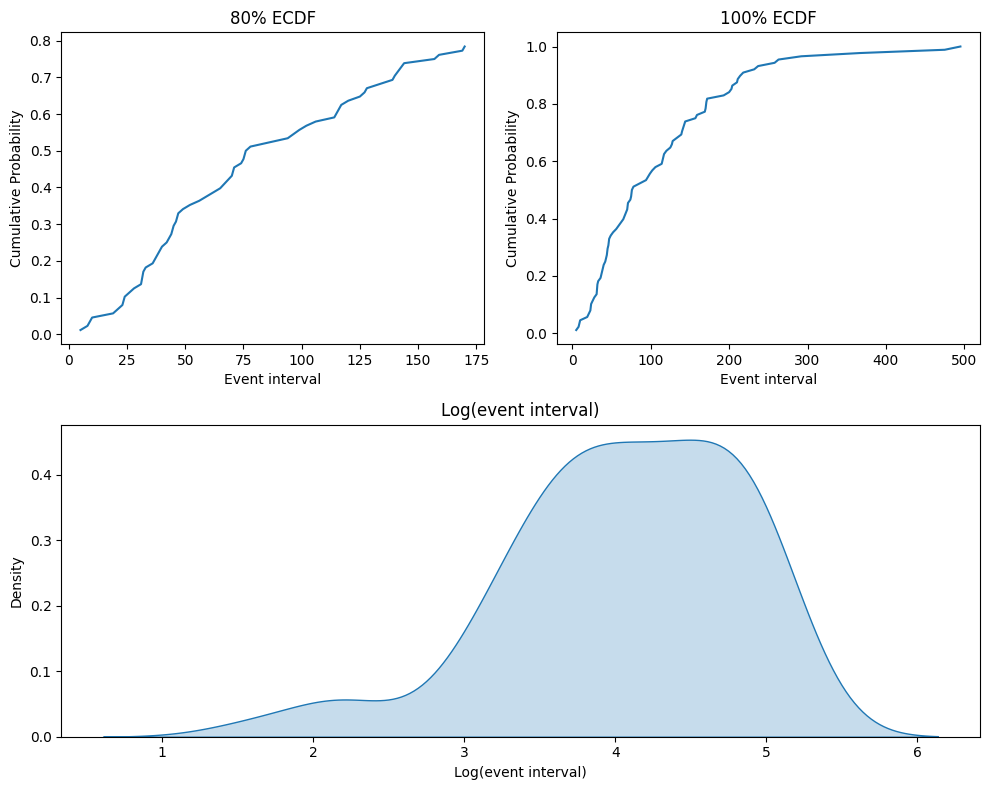

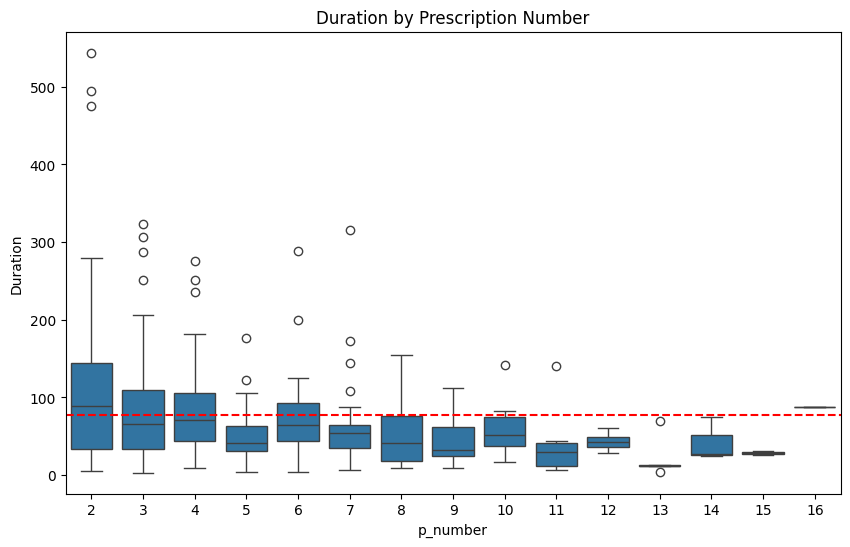

In [8]:
med_a_kmeans = SEE_KMeans("medA")

SEE_assumption(med_a_kmeans)

This will be our basis for comparing our result from KMeans clustering with DBSCAN for ATC `medA`. KMeans just simply provides a straightforward segmentation of the refill intervals.

### DBSCAN

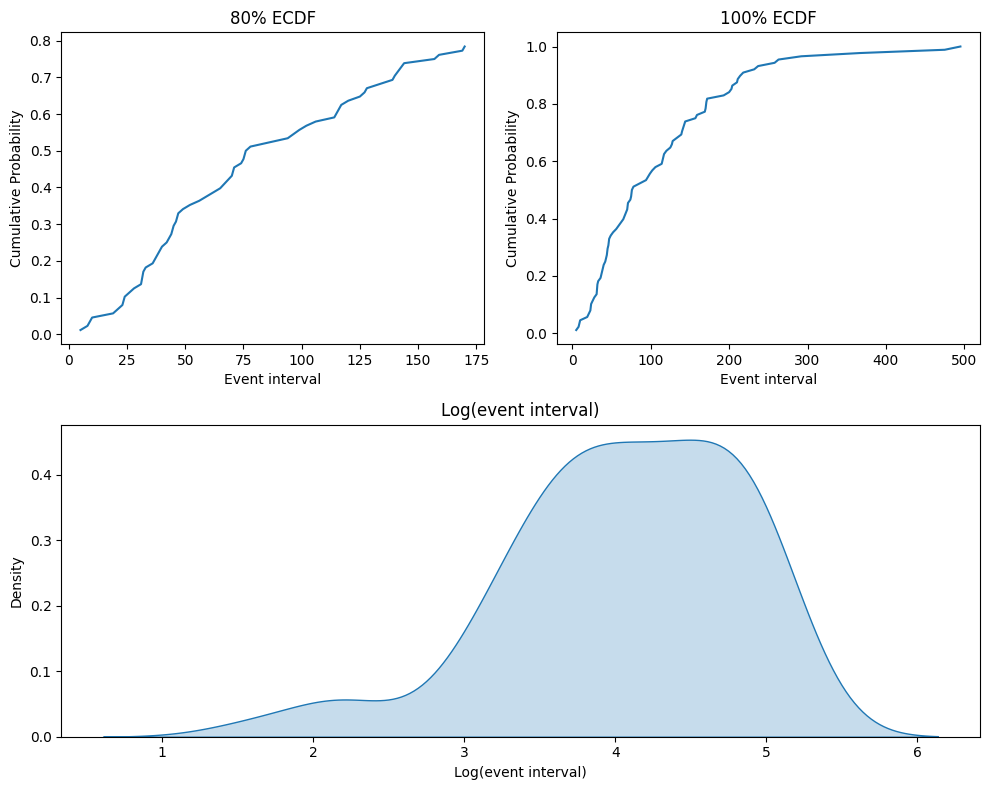

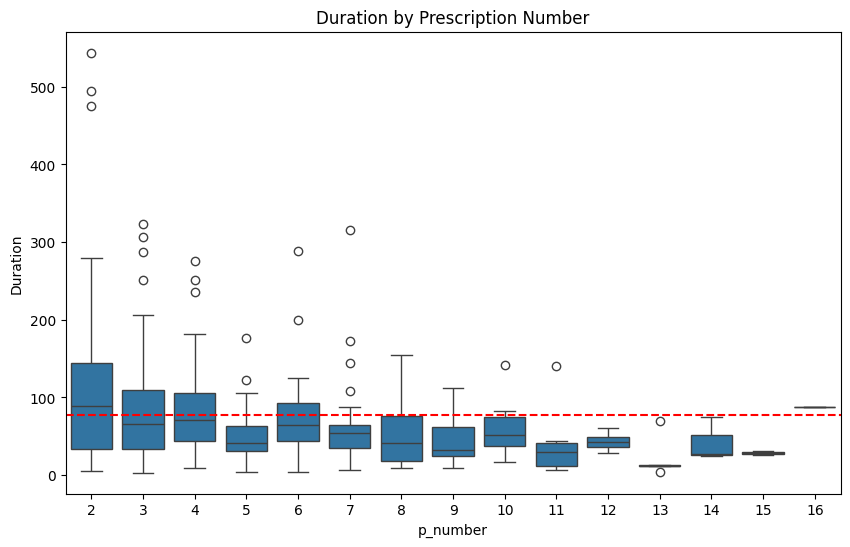

In [9]:
med_a_dbscan = SEE_DBSCAN("medA")

SEE_assumption(med_a_dbscan)

DBSCAN not only clusters the data but also effectively identifies noise points—highlighting irregular or atypical refill patterns that may otherwise distort the analysis. This capability of DBSCAN to isolate outliers offers deeper insights into the variability of refill behaviors and leads to more precise estimation of the median duration of medication events. 

### Comparison

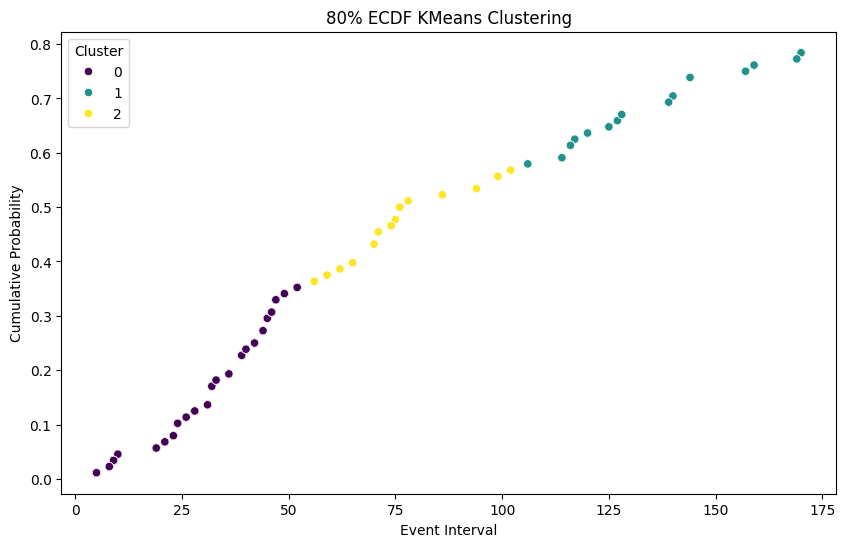

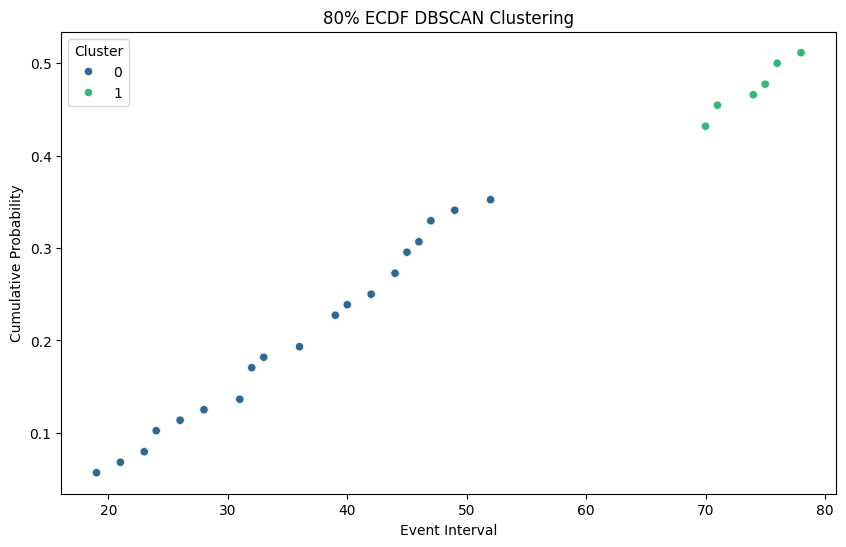

In [10]:
SEE_clustering_plot(med_a_kmeans, "KMeans")
SEE_clustering_plot(med_a_dbscan, "DBSCAN")

The plots above illustrate the clustering results from KMeans and DBSCAN for the refill data of ATC `medA`. In the KMeans plot, every data point is assigned to one of the predefined clusters, providing a clear segmentation of refill intervals. In contrast, the DBSCAN plot not only groups data points into clusters but also labels isolated points as noise (indicated by $-1$). These noise points are those that lie sufficiently far from other observations.

## SEE Clustering Comparision of ATC `medB`

### KMeans Clustering

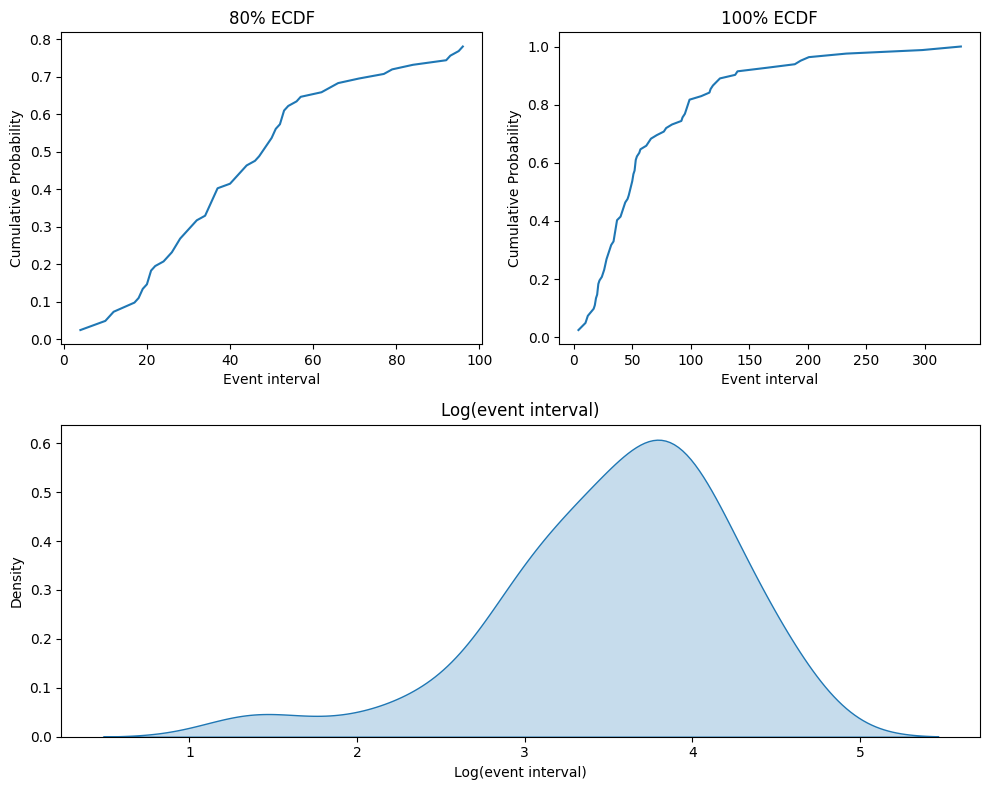

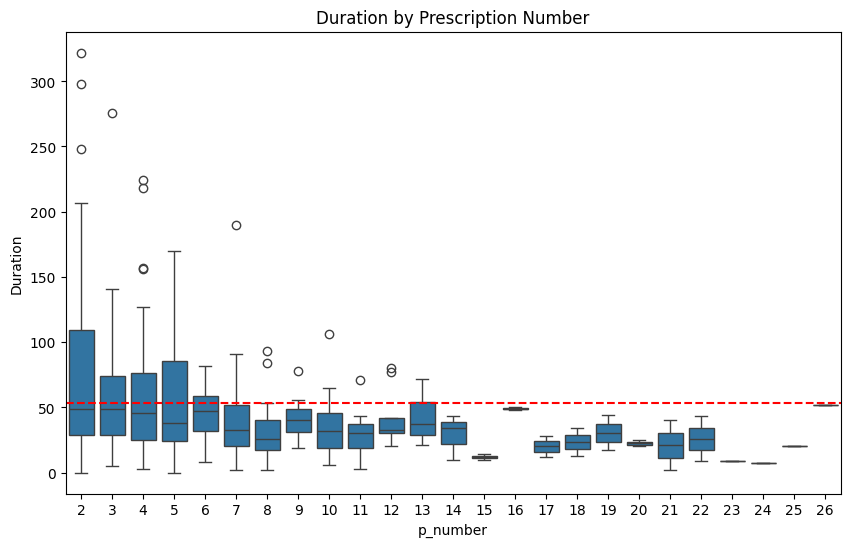

In [11]:
med_b_kmeans = SEE_KMeans("medB")

SEE_assumption(med_b_kmeans)

This will be our basis for comparing our result from KMeans clustering with DBSCAN for ATC `medB`. KMeans assigns every data point to a cluster, which gives us a clear segmentation of refill intervals.

### DBSCAN

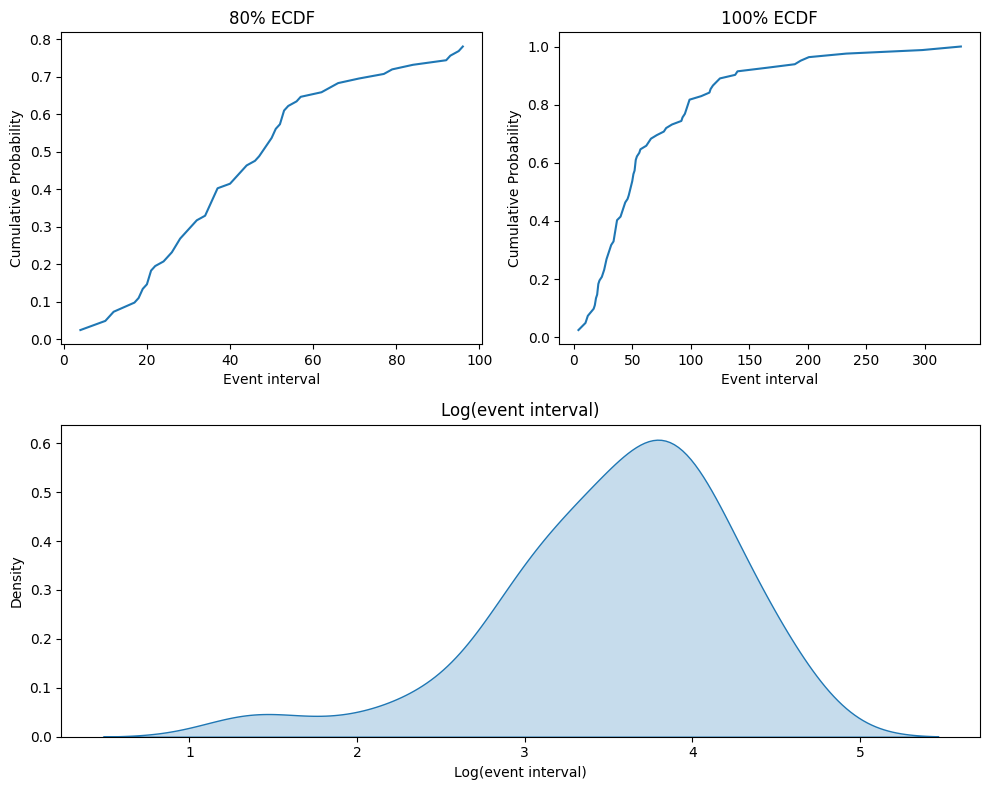

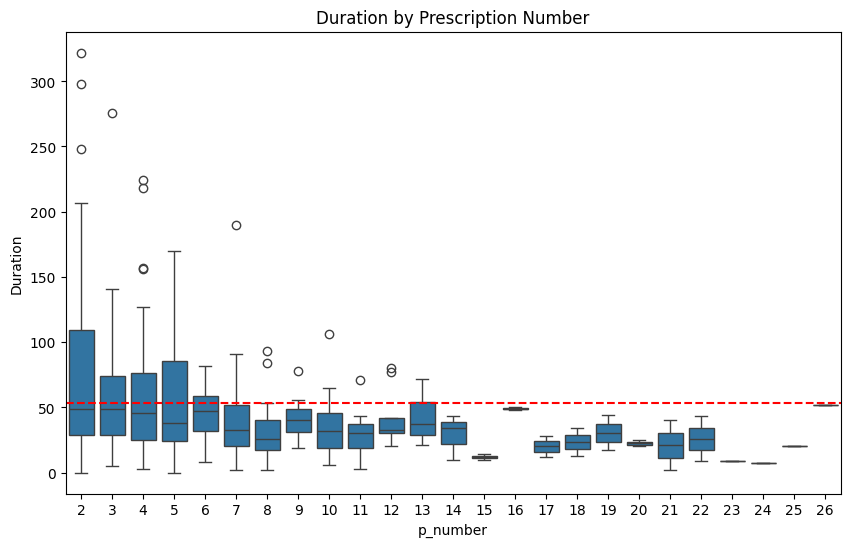

In [12]:
med_b_dbscan = SEE_DBSCAN("medB")

SEE_assumption(med_b_dbscan)

The DBSCAN plots reveal a stable structure in the lower $80$% of the ECDF, but we will know that it is actually not the case after this. As a result, the boxplot derived from DBSCAN shows a more refined and accurate median duration, which converges just below $25$ days. This demonstrates DBSCAN’s advantage in handling irregularities in the data and providing a more precise estimate of the refill duration.

### Comparison

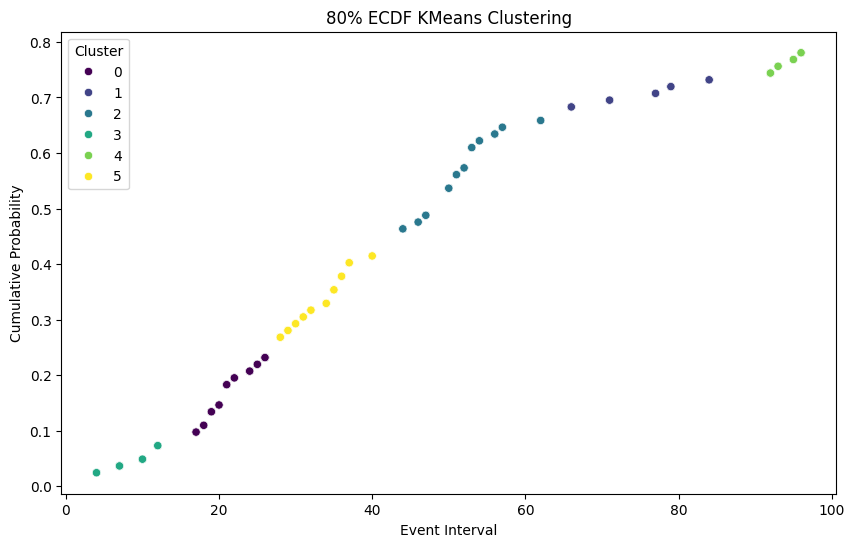

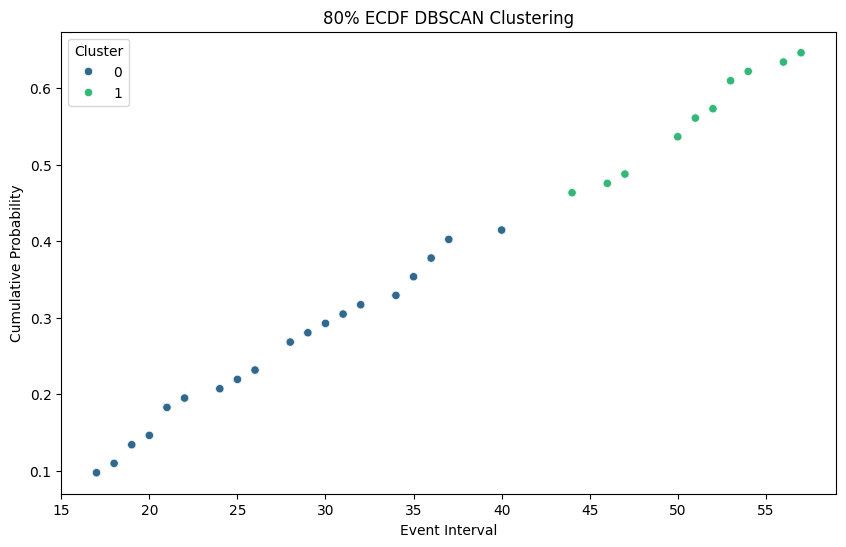

In [13]:
SEE_clustering_plot(med_b_kmeans, "KMeans")
SEE_clustering_plot(med_b_dbscan, "DBSCAN")

This comparison of the $80$% ECDF using both KMeans and DBSCAN reveals an important difference in how the two methods handle the data. KMeans assigns every point to a cluster regardless of its distance from others, while DBSCAN not only groups points into clusters but also identifies isolated points as noise (labeled as $-1$). This suggests that although the ECDF appears generally stable, DBSCAN’s detection of noise indicates that there may be underlying irregularities or outliers in the refill data. In other words, the apparent stability of the ECDF from earlier plots may mask subtle instabilities that become evident when using a clustering method capable of isolating anomalies.

## Conclusion

In this notebook we:

- Implemented the Sessa Empirical Estimator (SEE) in Python by simulating refill data, computing refill gaps, and filtering and standardizing these intervals.
- Applied K-Means clustering to group the filtered data and derived an estimated "duration" for each patient based on the median event interval within each cluster.
- Replaced K-Means with DBSCAN to overcome some of K-Means' limitations, particularly its inability to identify outliers.
- Compared the median "computed durations" from both methods to assess consistency and robustness.

Our analysis demonstrates that the SEE can effectively derive estimated medication event durations from refill data by first computing the empirical cumulative distribution (ECDF) of the refill gaps and then retaining the lower $80$% of these intervals. This filtering step minimizes the impact of extreme outliers—such as unusually long gaps due to treatment discontinuation—thus providing a more stable basis for clustering. 

K-Means clustering partitions all data points into predefined clusters, offering a clear segmentation of refill intervals. However, it does not account for data irregularities. In contrast, DBSCAN not only clusters the data but also labels isolated points as noise (assigned the label $-1$), which provides additional insight into the underlying variability of refill patterns. Even though the overall median durations from both methods were similar, DBSCAN’s ability to flag outliers underscores subtle instabilities in the refill data that might otherwise be overlooked.

### Insights

**ECDF and Filtering**  
- The ECDF plots for the $80$% and $100$% of refill intervals show that most gaps are confined to a predictable range. Discarding the upper $20$% helps remove the influence of extreme values that can distort duration estimates.

**Log Transformation**  
- Transforming the event intervals using the logarithm reduces skewness, thus normalizing the distribution. This transformation is essential for achieving more effective and reliable clustering.

**Clustering Comparison**  
- **K-Means:** Provides a straightforward segmentation by assigning every point to one of a fixed number of clusters, but it is sensitive to outliers and assumes clusters are spherical.  
- **DBSCAN:** Does not force every data point into a cluster; it detects noise points that fall outside dense regions. This ability to identify outliers offers deeper insight into refill irregularities and may result in more robust duration estimates.

**Practical Implications**  
- The estimated durations (i.e., the median values from each cluster) serve as a data-driven proxy for the true duration of medication events—a crucial measure when dosing information is incomplete.  
- The similarity in median estimates between the methods suggests that the overall structure of the refill data is robust. However, DBSCAN’s additional noise detection can be particularly useful in real-world scenarios where refill behaviors are more heterogeneous.

**Visualization Layout**  
- The combined subplot layout—displaying both the $80$% and $100$% ECDFs on the top row and the density of log-transformed event intervals on the bottom—provides a comprehensive visual summary. This layout facilitates intuitive comparisons and supports more informed decisions regarding thresholding and clustering parameters.

### Summary

By applying the SEE method with both K-Means and DBSCAN clustering on simulated refill data for ATC `medA` and `medB`, we have shown how data-driven techniques can be used to estimate medication event durations when direct dosing information is absent. Although both clustering methods produced similar median duration estimates, DBSCAN’s capability to isolate noise points reveals subtle irregularities in refill behavior that may impact exposure assessments. These insights can enhance the accuracy and interpretability of pharmacoepidemiological analyses.